Model działa na urządzeniu: cuda:0


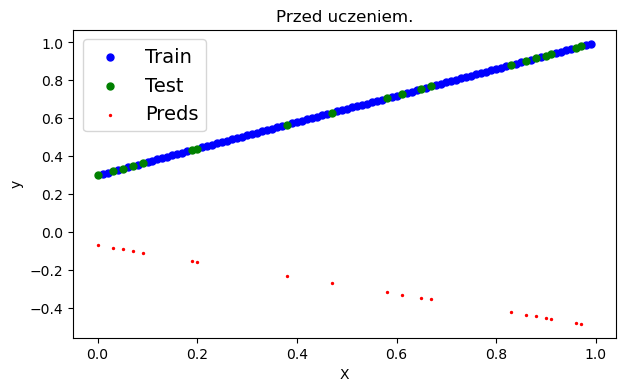

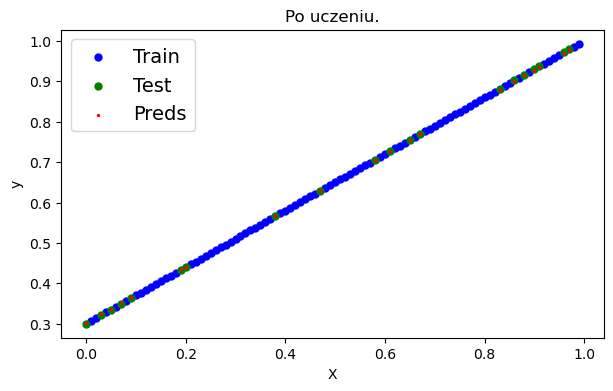

Przedstawienie wartości funkcji loss.


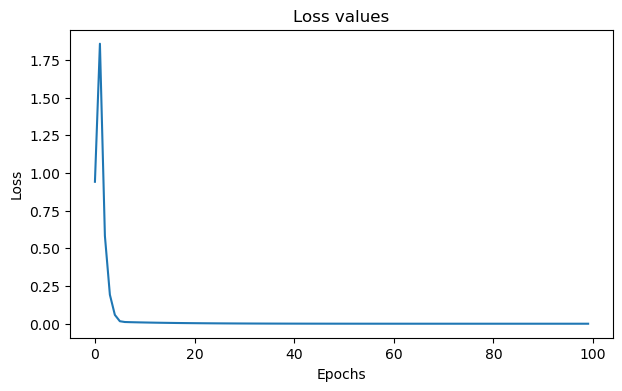

In [19]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

# ---------------------------------------------------------------------------------------------
def plot_prediction(X_train=None, y_train=None, X_test=None, y_test=None, y_preds=None, title=''):
    plt.figure(figsize=(7, 4))
    plt.scatter(X_train.cpu(), y_train.cpu(), c='b', s=25, label="Train")
    plt.scatter(X_test.cpu(), y_test.cpu(), c='g', s=25, label="Test")
    if y_preds is not None:
        plt.scatter(X_test.cpu(), y_preds.cpu(), c='r', s=2, label="Preds")
    plt.title(title)
    plt.ylabel('y')
    plt.xlabel('X')
    plt.legend(prop={'size':14})
    plt.show();

# ---------------------------------------------------------------------------------------------
def plot_loss_values(epoch_count=None, loss_values=None):
    plt.figure(figsize=(7, 4))
    plt.plot(epoch_count, np.array(torch.tensor(loss_values).cpu().numpy()))
    plt.title('Loss values')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.show();

# ---------------------------------------------------------------------------------------------
# przygotowanie danych
a = 0.7 
b = 0.3
X = torch.arange(start=0, end=1, step=0.01).unsqueeze(dim=1) # unsqueeze potrzebne do nn, dodanie dodatkowego wymiaru
y = a * X + b

# ---------------------------------------------------------------------------------------------
# rozdzielenie danych na treningowe i testowe
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# ---------------------------------------------------------------------------------------------
# klasa modelu
class ModelNN(nn.Module):
    def __init__(self):
        super().__init__()
        # https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
        self.layer_1 = nn.Linear(in_features=1, out_features=32) 
        self.layer_2 = nn.Linear(in_features=32, out_features=32) 
        self.layer_3 = nn.Linear(in_features=32, out_features=1) 
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))

# ---------------------------------------------------------------------------------------------
# instancja modelu
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model = ModelNN().to(device)

# ---------------------------------------------------------------------------------------------
# sprawdzenie na jakim urządzeniu działa model
print(f'Model działa na urządzeniu: {next(model.parameters()).device}')

# ---------------------------------------------------------------------------------------------
# przesłanie danych z cpu do gpu
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test  = y_test.to(device)

# ---------------------------------------------------------------------------------------------
# pierwsze przedstawoenie danych, przed uczeniem
# print(f'Parametry modelu random przed uczeniem: {model.state_dict()} Parametry rzeczywiste: a->{a}, b->{b}') 
with torch.inference_mode(): 
    y_preds = model(X_test)
plot_prediction(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, y_preds=y_preds, title='Przed uczeniem.') 

# ---------------------------------------------------------------------------------------------
# funkcja loss i ustawienie optymilizatora
# loss_fn = nn.L1Loss()
loss_fn = nn.MSELoss() # na tej działa szybciej i lepiej
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1) 

# ---------------------------------------------------------------------------------------------
# pętla trenowania
epochs = 100
epoch_count = []
loss_values = []

for epoch in range(epochs):
    model.train() # Ustawienie modułu w trybie treningowym.
    y_pred = model(X_train) # tu się uruchamia funkcja forward
    loss = loss_fn(y_pred, y_train) # obliczenie różnic
    optimizer.zero_grad() # optymalizacja parametrów, Resetuje gradienty wszystkich zoptymalizowanych :class:`torch.Tensor` s.
    loss.backward() # backpropagation, Oblicza gradient tensora aktualnego względem elementów grafu.
    optimizer.step() # Wykonuje pojedynczy krok optymalizacji.
    
    epoch_count.append(epoch)
    loss_values.append(loss)
    
# ---------------------------------------------------------------------------------------------
# przedstawoenie danych po uczeniu
# print(f'Parametry modelu po uczeniu: {model.state_dict()} Parametry rzeczywiste: a->{a}, b->{b}') 
model.eval() 
with torch.inference_mode(): 
    y_preds = model(X_test)
plot_prediction(X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, y_preds=y_preds, title='Po uczeniu.')     

# ---------------------------------------------------------------------------------------------
# przedstawienie wartości funkcji loss 
print(f'Przedstawienie wartości funkcji loss.')
plot_loss_values(epoch_count=epoch_count, loss_values=loss_values)